# Compute Capacity Analysis

This notebook analyzes compute capacities for various actors and visualizes the relationship between the available int8 operations and the number of stakeholders. It reads metadata from Markdown files, compiles them into a CSV, and then generates an SVG scatter plot with neatly arranged labels.

## Imports and Setup

In the first code cell we import standard Python libraries used throughout the notebook. `os` and `csv` help with file system access and CSV creation, `math` enables logarithmic scaling, and `matplotlib` draws the final chart. These libraries are part of the base Python environment in this project, so no external installations are necessary.

In [169]:

# Import modules for file handling, mathematics, and plotting
import os
import csv
import math
from pathlib import Path
import yaml
import matplotlib.pyplot as plt


## Collect front matter and build `data.csv`

The Markdown files in the `entities` directory store metadata about each actor in a YAML front‑matter block. This code walks through every `.md` file in that directory, extracts the `name`, `compute` (renamed to `ops`), and `stakeholder` (renamed to `stakeholders`) fields, converts them to numeric types, and writes them out to a CSV file called `data.csv`. This CSV will be used for plotting in the next step.

In [170]:
# Define where to look for Markdown files containing compute metadata
try:
    base_dir = Path(__file__).parent
except NameError:
    base_dir = Path.cwd()

entities_dir = base_dir / 'entities'

if not entities_dir.exists():
    raise FileNotFoundError(f"{entities_dir} does not exist")
if not any(entities_dir.rglob('*.md')):
    raise FileNotFoundError(f"No Markdown files found in {entities_dir}")
# Prepare a list to hold the parsed rows
rows = []

for root, dirs, files in os.walk(entities_dir):
    for fname in files:
        if fname.endswith('.md'):
            path = os.path.join(root, fname)
            with open(path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
            # Extract front matter lines between the first two '---'
            in_front_matter = False
            front_lines = []
            for line in lines:
                if line.strip() == '---':
                    if not in_front_matter:
                        in_front_matter = True
                        continue
                    else:
                        # end of front matter
                        break
                if in_front_matter:
                    front_lines.append(line)
            # Parse front matter as YAML
            front_text = ''.join(front_lines)
            data = yaml.safe_load(front_text) or {}
            # Fetch required metadata fields from the front matter
            name = data.get('name')
            compute = data.get('compute')
            stakeholder = data.get('stakeholder')
            category = data.get('category')
            if name is None or compute is None or stakeholder is None or category is None:
                continue
            # Parse compute as float (scientific notation allowed)
            try:
                ops_value = float(compute)
            except ValueError:
                # Try to convert with replacements
                tmp = str(compute).lower().replace('×', 'e').replace('^', '')
                tmp = tmp.replace('int8', '')
                try:
                    ops_value = float(tmp)
                except Exception:
                    continue
            try:
                stakeholders_value = int(float(stakeholder))
            except ValueError:
                continue
            # Skip entries with zero compute
            if ops_value == 0:
                continue
            # Record the parsed values
            rows.append((name, category, ops_value, stakeholders_value))

# Write the collected data to a CSV file
csv_path = 'data.csv'
with open(csv_path, 'w', newline='', encoding='utf-8') as file_out:
    writer = csv.writer(file_out)
    writer.writerow(['name', 'category', 'ops', 'stakeholders'])
    for row in rows:
        writer.writerow(row)

# Print a preview of the rows collected
print(f"Collected {len(rows)} entries:")
for r in rows:
    print(r)


Collected 40 entries:
('Alphabet', 'institutions', 1e+20, 15)
('Amazon', 'institutions', 4e+19, 15)
('Apple', 'institutions', 2e+18, 12)
('California State University', 'academia', 2e+16, 200)
('Coral USB Accelerator', 'individuals', 4000000000000.0, 1)
('Elon Musk', 'oligarchs', 4e+20, 1)
('ETH Zürich', 'academia', 2e+17, 70)
('European Union', 'state-actors', 1.4e+19, 100)
('Galaxy S24 Ultra', 'individuals', 45000000000000.0, 1)
('Government of India', 'state-actors', 1e+16, 100)
('Government of Japan', 'state-actors', 4e+18, 200)
('Indian Institute of Science', 'academia', 3e+16, 50)
('iPhone 16', 'individuals', 8600000000000.0, 1)
('Jetson Orin NX', 'individuals', 100000000000000.0, 1)
('MacBook M3', 'individuals', 18000000000000.0, 1)
('Meta', 'institutions', 1e+19, 15)
('Microsoft', 'institutions', 4e+20, 15)
('Moscow State University', 'academia', 2e+17, 70)
('National University of Singapore', 'academia', 8e+16, 60)
('Peking University', 'academia', 1e+17, 60)
("People's Republ

This final step reads the data, colors each point by its category, and draws a key to explain the colors. Both axes use logarithmic scales: the horizontal axis for stakeholder counts and the vertical axis for estimated int8 operations per second. Most labels appear on the right side of the chart with connector lines. Labels for entries in the 'individuals' and 'oligarchs' categories sit on the left to keep the plot balanced.


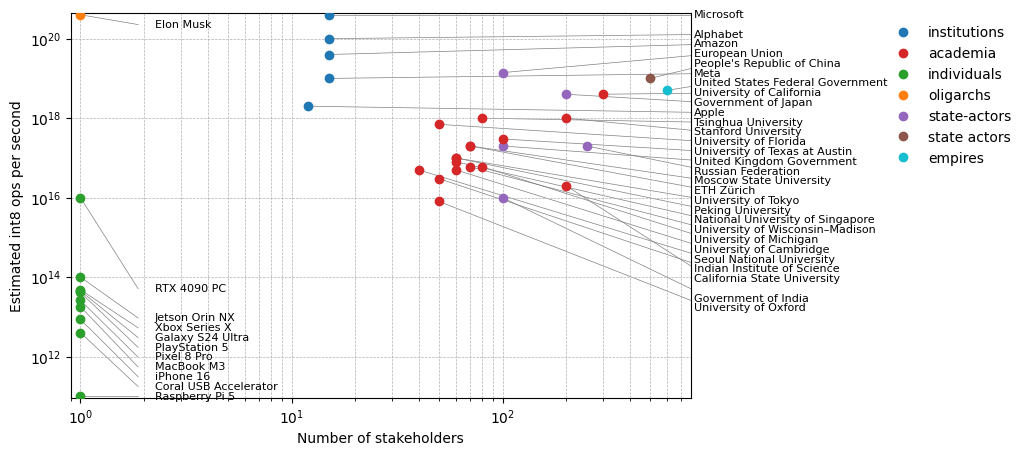

In [171]:
# Read the data from the CSV file
points = []
with open('data.csv', 'r', encoding='utf-8') as file_in:
    reader = csv.DictReader(file_in)
    for row in reader:
        name = row['name']
        ops = float(row['ops'])
        stakeholders = float(row['stakeholders'])
        category = row['category']
        point = {
            'name': name,
            'ops': ops,
            'stakeholders': stakeholders,
            'category': category,
        }
        points.append(point)

# Ensure there is data to plot
if not points:
    raise ValueError('No data points found in data.csv')

# Compute axis ranges
ops_values = [p['ops'] for p in points]
stakeholder_values = [p['stakeholders'] for p in points]
min_ops = min(ops_values)
max_ops = max(ops_values)
min_stakeholder = min(stakeholder_values)
max_stakeholder = max(stakeholder_values)

# Define figure dimensions in pixels and convert to inches for matplotlib
fig_width, fig_height = 800, 500
dpi = 100
fig, ax = plt.subplots(figsize=(fig_width / dpi, fig_height / dpi), dpi=dpi)

# Set up axes
ax.set_xlabel('Number of stakeholders')
ax.set_ylabel('Estimated int8 ops per second')
ax.set_xscale('log')
ax.set_yscale('log')
x_min = min_stakeholder * 0.9
x_max = max_stakeholder * 1.3
ax.set_xlim(x_min, x_max)
ax.set_ylim(min_ops * 0.9, max_ops * 1.1)

# Assign colors to each category
primary_colors = [
    'tab:blue',
    'tab:red',
    'tab:green',
    'tab:orange',
    'tab:purple',
    'tab:brown',
    'tab:cyan',
]
series_colors = {}
for point in points:
    category = point['category']
    if category not in series_colors:
        color_index = len(series_colors)
        series_colors[category] = primary_colors[color_index % len(primary_colors)]

# Plot the points with category colors
for point in points:
    color = series_colors[point['category']]
    ax.scatter(point['stakeholders'], point['ops'], color=color, zorder=3)

# Sort points by log-scale y coordinate to determine label placement
sorted_points = sorted(points, key=lambda p: math.log10(p['ops']))

# Calculate label y positions evenly spaced along the plotting area
n = len(sorted_points)
if n > 1:
    y_min_log = math.log10(min_ops)
    y_max_log = math.log10(max_ops)
    spacing = (y_max_log - y_min_log) / (n - 1)
    y_positions = [10 ** (y_min_log + i * spacing) for i in range(n)]
else:
    y_positions = [min_ops]

# Place labels on both sides of the figure
# Labels for individuals and oligarchs sit on the left for balance
left_categories = {'individuals', 'oligarchs'}
label_x_right = max_stakeholder * 1.35
anchor_right = label_x_right * 1.2
label_x_left = x_min / .4
anchor_left = label_x_left / 1.2
for point, label_y in zip(sorted_points, y_positions):
    if point['category'] in left_categories:
        x_text = label_x_left
        x_anchor = anchor_left
        align = 'left'
    else:
        x_text = label_x_right
        x_anchor = anchor_right
        align = 'left'
    ax.plot(
        [point['stakeholders'], x_anchor],
        [point['ops'], label_y],
        color='gray',
        linewidth=0.5,
        zorder=1,
    )
    ax.text(
        x_text,
        label_y,
        point['name'],
        va='center',
        ha=align,
        fontsize=8,
        zorder=2,
    )

# Add grid for readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)

# Draw a legend showing category colors
legend_handles = []
for category, color in series_colors.items():
    handle = plt.Line2D([], [], marker='o', linestyle='', color=color, label=category)
    legend_handles.append(handle)
ax.legend(
    handles=legend_handles,
    loc='upper left',
    bbox_to_anchor=(1.3, 1),
    frameon=False,
)

# Save the figure as an SVG file
svg_filename = 'chart.svg'
fig.savefig(svg_filename, format='svg', bbox_inches='tight')

# Display the SVG inline
from IPython.display import SVG, display as display_svg
with open(svg_filename, 'r', encoding='utf-8') as f:
    svg_content = f.read()
# display_svg(SVG(svg_content))
